In [3]:
climate4R <- list("loadeR", "transformeR", "downscaleR", "visualizeR", "climate4R.climdex")
lapply(climate4R, require, character.only = TRUE) 

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

In [4]:
library(devtools)
library(tidyverse)
library(caret)

In [5]:
library(RColorBrewer)
colstx <- rev(brewer.pal(n = 9, "Spectral"))
colsindex <- rev(brewer.pal(n = 9, "RdYlBu"))
colsdelta <- brewer.pal(n = 9, "Reds")
colsbias <- brewer.pal(n = 9, "PiYG")
colssd <- brewer.pal(n = 9, "Blues")

In [6]:
load("./pr_MAM.rda",verbose = T)
load("./tas_MAM.rda",verbose = T)
load("./indices_MAM.rda",verbose = T)
load("./indices_MAM_LT1.rda",verbose = T)
load("./indices_MAM_LT4.rda",verbose = T)

Loading objects:
  data_MAM
Loading objects:
  data_MAM_temp
Loading objects:
  indices_MAM
Loading objects:
  indices_MAM_LT1
Loading objects:
  indices_MAM_LT4


In [7]:
# métrica de validación: RMSE
rmse <- function(obs, pred) {  
  sqrt(mean((obs - pred)^2,na.rm = TRUE))
  
}
# métrica de años acertados
acc <- function(obs,pred){
    terciles = quantile(obs, probs = c(.33,.66,1), na.rm = TRUE)
    if (terciles[1]==terciles[2]){
        terciles[2] = terciles[1] + 1/10000
    }
    if (terciles[1]==terciles[3]){
        terciles[3] = terciles[1] + 1/10000
    }
    if (terciles[2]==terciles[3]){
        terciles[3] = terciles[2] + 1/10000
    }
    x = cut(obs, breaks = c(-Inf,terciles), labels = c("lower","mid",
                                                 "upper"))
    terciles_pred = quantile(pred, probs = c(.33,.66,1), na.rm = TRUE)
    if (terciles_pred[1]==terciles_pred[2]){
        terciles_pred[2] = terciles_pred[1] + 1/10000
    }
    if (terciles_pred[1]==terciles_pred[3]){
        terciles_pred[3] = terciles_pred[1] + 1/10000
    }
    if (terciles_pred[2]==terciles_pred[3]){
        terciles_pred[3] = terciles_pred[2] + 1/10000
    }
    y = cut(pred, breaks = c(-Inf,terciles_pred), labels = c("lower","mid",
                                                 "upper"))
    z = length(which(x==y))
    
    return (z/length(obs))
}

In [8]:
library("randomForest")

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin




In [9]:
predict_pr_rf = data_MAM
predict_tas_rf = data_MAM_temp
predict_pr_rf_LT1 = data_MAM
predict_tas_rf_LT1 = data_MAM_temp
predict_pr_rf_LT4 = data_MAM
predict_tas_rf_LT4 = data_MAM_temp

In [10]:
nTrees_pr = matrix(NA,ncol=length(data_MAM$xyCoords$x), nrow = length(data_MAM$xyCoords$y))
for (i in 1:length(data_MAM$xyCoords$x)) {
    for (j in 1:length(data_MAM$xyCoords$y)) {
        if (length(which(!is.na(data_MAM$Data[, j, i]))) > 2) {
            indices_MAM$grid <- as.numeric(data_MAM$Data[, j, i])
            model_rf = randomForest(grid ~ ., indices_MAM[1:36,],ntree = 1000)
            ntree = which.min(model_rf$mse)
            
            nTrees_pr[j,i] = ntree
                  
        }
        
    }
}


Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning messa

In [11]:
nTrees_tas = matrix(NA,ncol=length(data_MAM$xyCoords$x), nrow = length(data_MAM$xyCoords$y))
for (i in 1:length(data_MAM_temp$xyCoords$x)) {
    for (j in 1:length(data_MAM_temp$xyCoords$y)) {
        if (length(which(!is.na(data_MAM_temp$Data[, j, i]))) > 2) {
            indices_MAM$grid <- as.numeric(data_MAM_temp$Data[, j, i])
            model_rf = randomForest(grid ~ ., indices_MAM[1:36,],ntree = 1000)
            ntree = which.min(model_rf$mse)
            
            nTrees_tas[j,i] = ntree
        }
        
    }
}

In [12]:
save(nTrees_pr, file = "nTrees_pr.rda")
save(nTrees_tas, file = "nTrees_tas.rda")

In [13]:
makeC4R = function(data, template) {  # creates a C4R object from the "data" matrix
  C4R = template; C4R$Data = data; attributes(C4R$Data) = attributes(template$Data)
  return(C4R)
}
template = subsetDimension(data_MAM, dimension = "time", indices = 1)
nTrees_pr_graph= makeC4R(nTrees_pr,template)
nTrees_tas_graph= makeC4R(nTrees_tas,template)

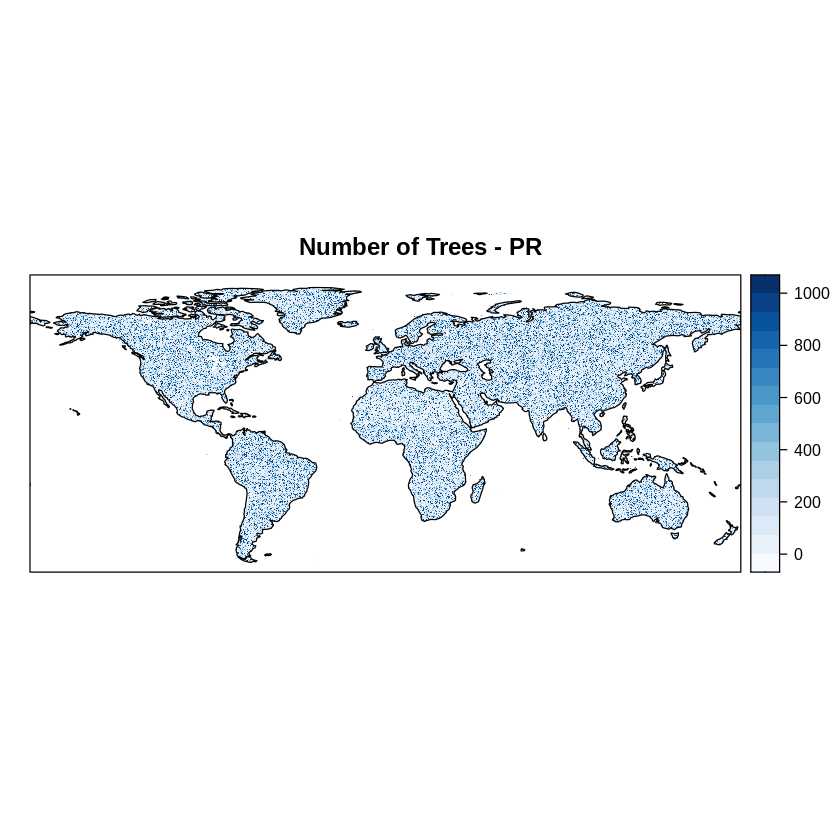

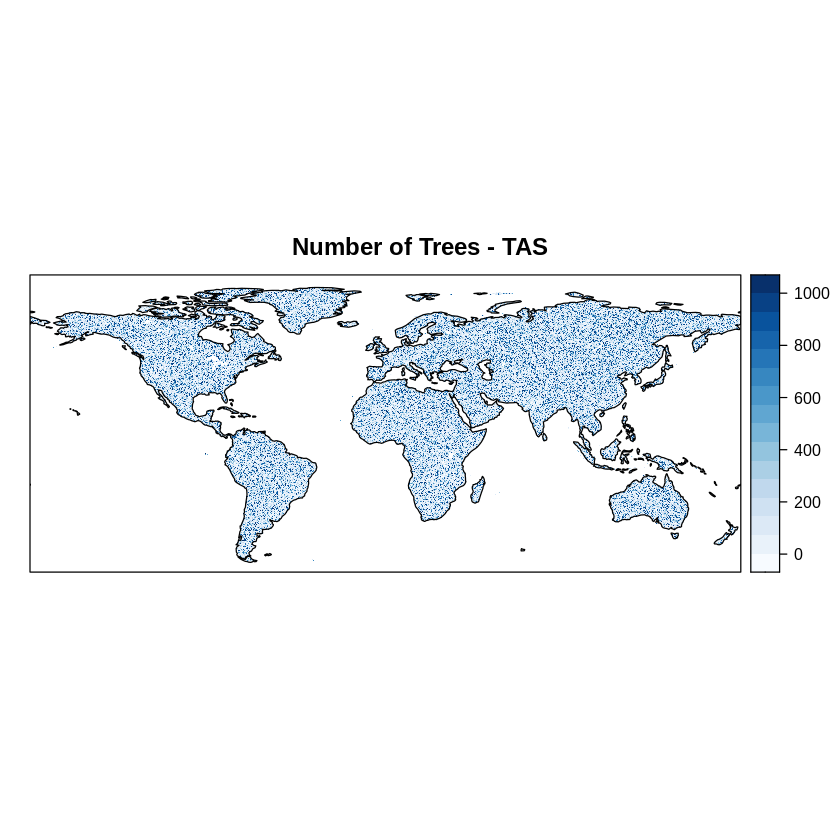

In [14]:
spatialPlot(nTrees_pr_graph, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'Number of Trees - PR')
spatialPlot(nTrees_tas_graph, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'Number of Trees - TAS')

In [15]:
start_time = Sys.time()

for(iyear in 1:dim(data_MAM$Data)[1]){
    for(i in 1:length(data_MAM$xyCoords$x)){
        for(j in 1:length(data_MAM$xyCoords$y)){
            if(length(which(is.na(data_MAM$Data[,j,i])==FALSE))>2){
                indices_MAM$grid <- as.numeric(data_MAM$Data[, j, i])
                indices_MAM_LT1$grid = as.numeric(data_MAM$Data[, j, i])
                indices_MAM_LT4$grid = as.numeric(data_MAM$Data[, j, i])
                
                model_rf = randomForest(grid ~ ., indices_MAM[-iyear,],ntree = nTrees_pr[j,i])

                pred= predict(model_rf, indices_MAM[iyear,])
                pred_LT1 = predict(model_rf, indices_MAM_LT1[iyear,])
                pred_LT4 = predict(model_rf, indices_MAM_LT4[iyear,])
                
                predict_pr_rf$Data[iyear,j,i] = pred
                predict_pr_rf_LT1$Data[iyear, j, i] <- pred_LT1
                predict_pr_rf_LT4$Data[iyear, j, i] <- pred_LT4
            }
        }
    }
}

end_time = Sys.time()
print(end_time - start_time)


Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning messa

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning messa

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning messa

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning messa

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning messa

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning messa

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning messa

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning messa

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning messa

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning messa

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning messa

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning messa

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning messa

Time difference of 5.619578 hours


In [16]:
start_time = Sys.time()

for(iyear in 1:dim(data_MAM_temp$Data)[1]){
    for(i in 1:length(data_MAM_temp$xyCoords$x)){
        for(j in 1:length(data_MAM_temp$xyCoords$y)){
            if(length(which(is.na(data_MAM_temp$Data[,j,i])==FALSE))>2){
                indices_MAM$grid <- as.numeric(data_MAM_temp$Data[, j, i])
                indices_MAM_LT1$grid = as.numeric(data_MAM_temp$Data[, j, i])
                indices_MAM_LT4$grid = as.numeric(data_MAM_temp$Data[, j, i])
                
                model_rf = randomForest(grid ~ ., indices_MAM[-iyear,],ntree = nTrees_tas[j,i])

                pred= predict(model_rf, indices_MAM[iyear,])
                pred_LT1 = predict(model_rf, indices_MAM_LT1[iyear,])
                pred_LT4 = predict(model_rf, indices_MAM_LT4[iyear,])
                
                predict_tas_rf$Data[iyear,j,i] = pred
                predict_tas_rf_LT1$Data[iyear, j, i] <- pred_LT1
                predict_tas_rf_LT4$Data[iyear, j, i] <- pred_LT4
            }
        }
    }
}

end_time = Sys.time()
print(end_time - start_time)

Time difference of 5.562165 hours


In [17]:
save(predict_pr_rf, file = "predict_pr_rf.rda") 
save(predict_tas_rf, file = "predict_tas_rf.rda") 
save(predict_pr_rf_LT1, file = "predict_pr_rf_LT1.rda") 
save(predict_tas_rf_LT1, file = "predict_tas_rf_LT1.rda") 
save(predict_pr_rf_LT4, file = "predict_pr_rf_LT4.rda") 
save(predict_tas_rf_LT4, file = "predict_tas_rf_LT4.rda")

In [18]:
rmse_pr_rf = matrix(NA, nrow = length(data_MAM$xyCoords$y), ncol = length(data_MAM$xyCoords$x))
acc_pr_rf = matrix(NA, nrow = length(data_MAM$xyCoords$y), ncol = length(data_MAM$xyCoords$x))
rmse_pr_rf_LT1 = matrix(NA, nrow = length(data_MAM$xyCoords$y), ncol = length(data_MAM$xyCoords$x))
acc_pr_rf_LT1 = matrix(NA, nrow = length(data_MAM$xyCoords$y), ncol = length(data_MAM$xyCoords$x))
rmse_pr_rf_LT4 = matrix(NA, nrow = length(data_MAM$xyCoords$y), ncol = length(data_MAM$xyCoords$x))
acc_pr_rf_LT4 = matrix(NA, nrow = length(data_MAM$xyCoords$y), ncol = length(data_MAM$xyCoords$x))
for(i in 1:length(data_MAM$xyCoords$x)){
    for(j in 1:length(data_MAM$xyCoords$y)){
        if(length(which(is.na(data_MAM$Data[,j,i])==FALSE))>2){
            rmse_pr_rf[j,i] = rmse(data_MAM$Data[,j,i],predict_pr_rf$Data[,j,i])
            acc_pr_rf[j,i] = acc(data_MAM$Data[,j,i],predict_pr_rf$Data[,j,i])
            
            rmse_pr_rf_LT1[j,i] = rmse(data_MAM$Data[,j,i],predict_pr_rf_LT1$Data[,j,i])
            acc_pr_rf_LT1[j,i] = acc(data_MAM$Data[,j,i],predict_pr_rf_LT1$Data[,j,i])
            
            rmse_pr_rf_LT4[j,i] = rmse(data_MAM$Data[,j,i],predict_pr_rf_LT4$Data[,j,i])
            acc_pr_rf_LT4[j,i] = acc(data_MAM$Data[,j,i],predict_pr_rf_LT4$Data[,j,i])
            
       }
    }
}

rmse_tas_rf = matrix(NA, nrow = length(data_MAM_temp$xyCoords$y), ncol = length(data_MAM_temp$xyCoords$x))
acc_tas_rf= matrix(NA, nrow = length(data_MAM_temp$xyCoords$y), ncol = length(data_MAM_temp$xyCoords$x))
rmse_tas_rf_LT1 = matrix(NA, nrow = length(data_MAM_temp$xyCoords$y), ncol = length(data_MAM_temp$xyCoords$x))
acc_tas_rf_LT1= matrix(NA, nrow = length(data_MAM_temp$xyCoords$y), ncol = length(data_MAM_temp$xyCoords$x))
rmse_tas_rf_LT4 = matrix(NA, nrow = length(data_MAM_temp$xyCoords$y), ncol = length(data_MAM_temp$xyCoords$x))
acc_tas_rf_LT4 = matrix(NA, nrow = length(data_MAM_temp$xyCoords$y), ncol = length(data_MAM_temp$xyCoords$x))
for(i in 1:length(data_MAM_temp$xyCoords$x)){
    for(j in 1:length(data_MAM_temp$xyCoords$y)){
        if(length(which(is.na(data_MAM_temp$Data[,j,i])==FALSE))>2){
            rmse_tas_rf[j,i] = rmse(data_MAM_temp$Data[,j,i],predict_tas_rf$Data[,j,i])
            acc_tas_rf[j,i] = acc(data_MAM_temp$Data[,j,i],predict_tas_rf$Data[,j,i])
            
            rmse_tas_rf_LT1[j,i] = rmse(data_MAM_temp$Data[,j,i],predict_tas_rf_LT1$Data[,j,i])
            acc_tas_rf_LT1[j,i] = acc(data_MAM_temp$Data[,j,i],predict_tas_rf_LT1$Data[,j,i])
            
            rmse_tas_rf_LT4[j,i] = rmse(data_MAM_temp$Data[,j,i],predict_tas_rf_LT4$Data[,j,i])
            acc_tas_rf_LT4[j,i] = acc(data_MAM_temp$Data[,j,i],predict_tas_rf_LT4$Data[,j,i])
       }
    }
}

In [19]:
makeC4R = function(data, template) {  # creates a C4R object from the "data" matrix
  C4R = template; C4R$Data = data; attributes(C4R$Data) = attributes(template$Data)
  return(C4R)
}
template = subsetDimension(data_MAM, dimension = "time", indices = 1)
rmse_pr_rf= makeC4R(rmse_pr_rf,template)
acc_pr_rf= makeC4R(acc_pr_rf,template)
rmse_pr_rf_LT1 = makeC4R(rmse_pr_rf_LT1,template)
acc_pr_rf_LT1 = makeC4R(acc_pr_rf_LT1,template)
rmse_pr_rf_LT4= makeC4R(rmse_pr_rf_LT4,template)
acc_pr_rf_LT4= makeC4R(acc_pr_rf_LT4,template)

rmse_tas_rf= makeC4R(rmse_tas_rf,template)
acc_tas_rf= makeC4R(acc_tas_rf,template)
rmse_tas_rf_LT1= makeC4R(rmse_tas_rf_LT1,template)
acc_tas_rf_LT1= makeC4R(acc_tas_rf_LT1,template)
rmse_tas_rf_LT4= makeC4R(rmse_tas_rf_LT4,template)
acc_tas_rf_LT4= makeC4R(acc_tas_rf_LT4,template)

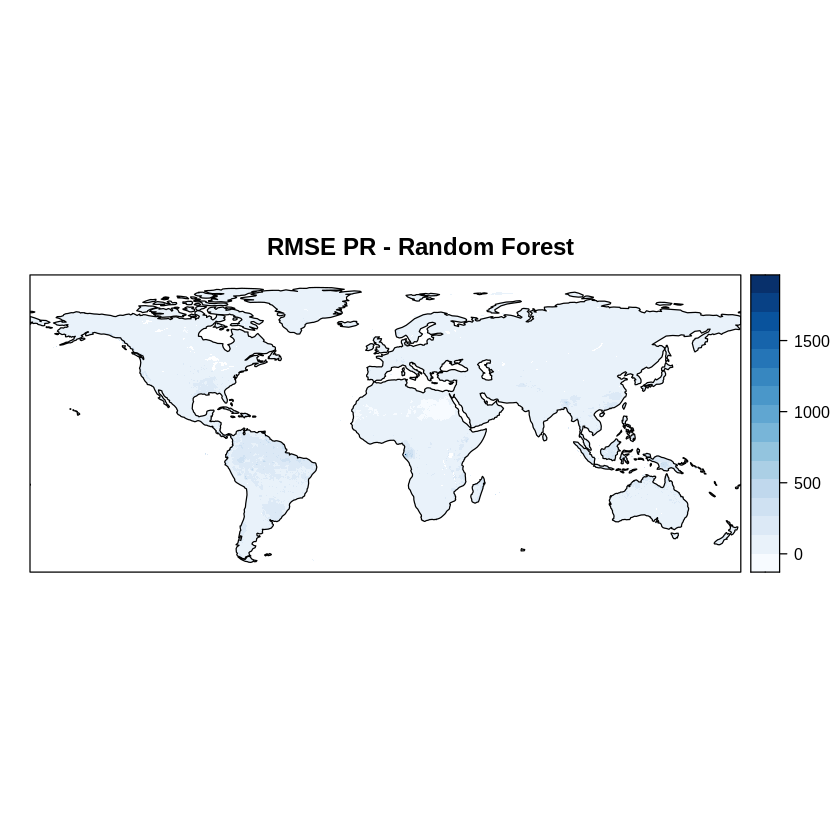

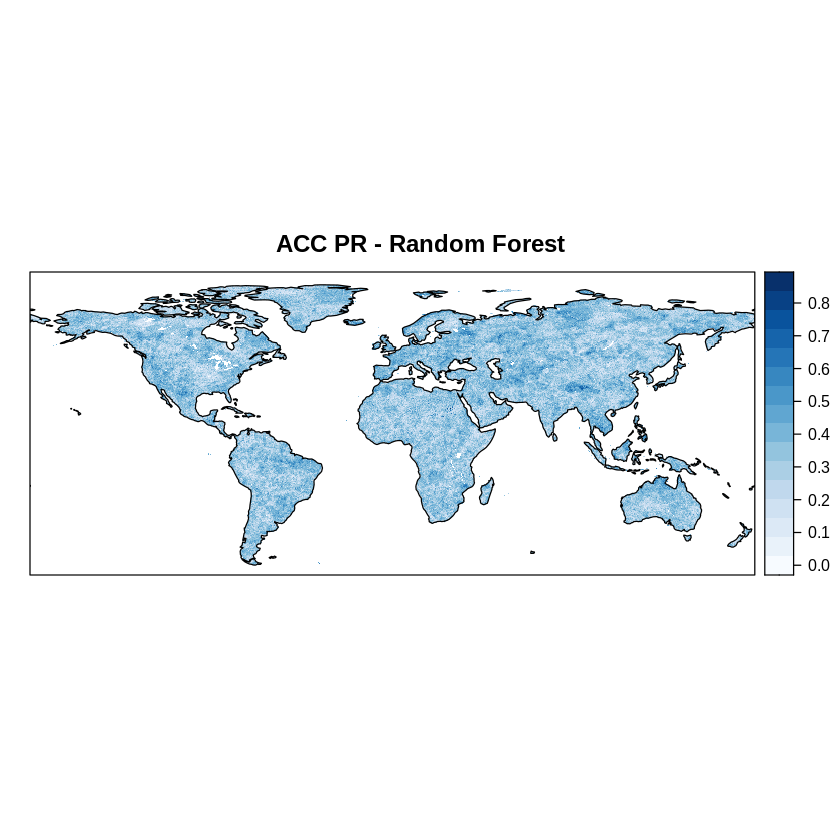

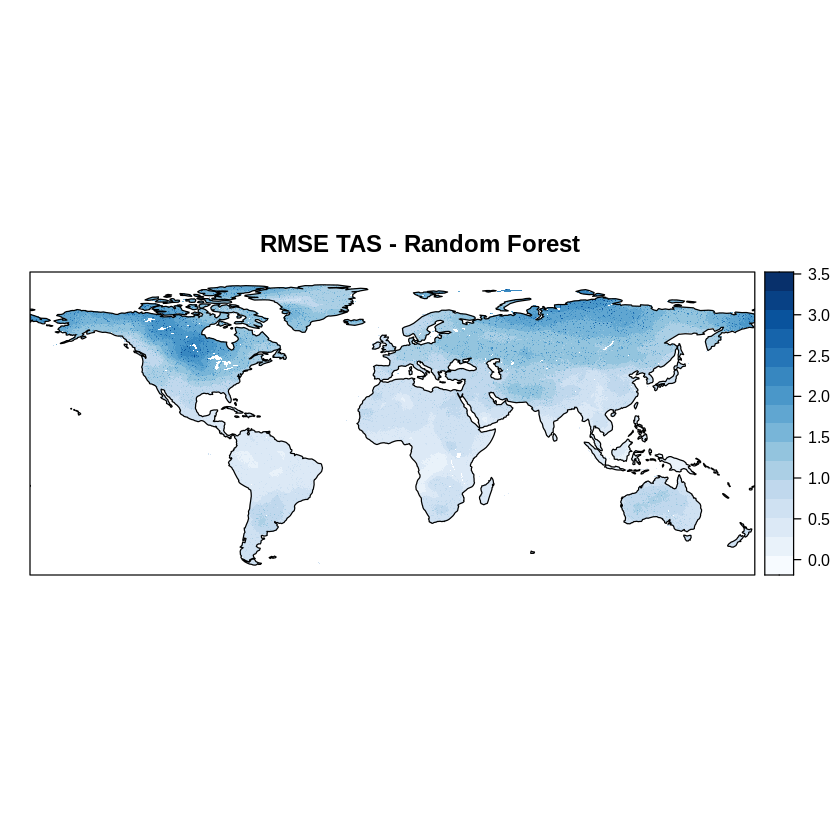

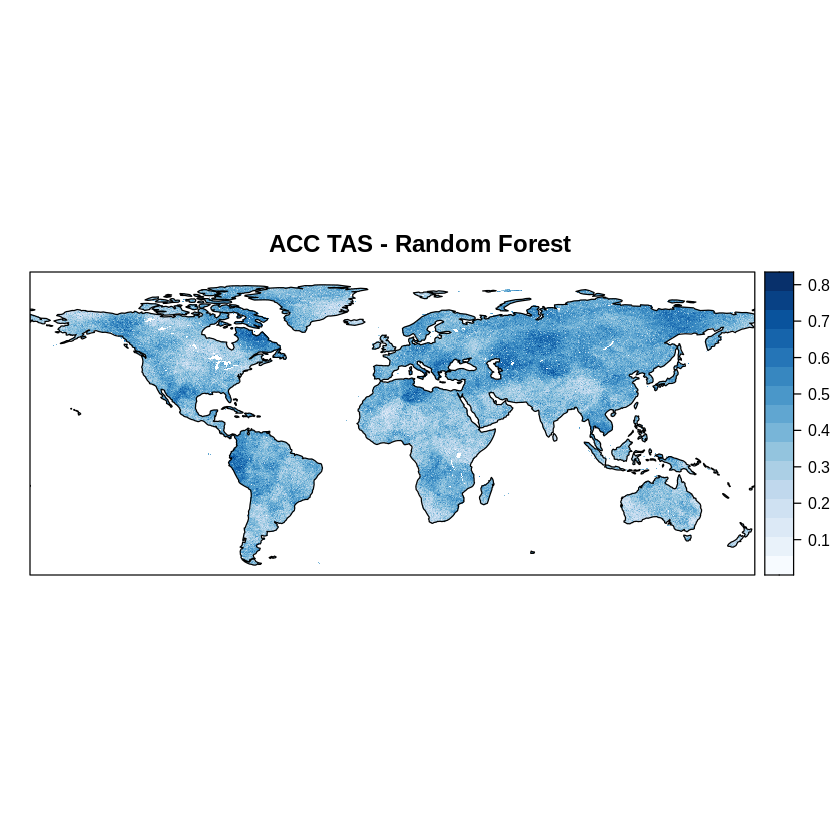

In [20]:
spatialPlot(rmse_pr_rf, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'RMSE PR - Random Forest')
spatialPlot(acc_pr_rf, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'ACC PR - Random Forest')
spatialPlot(rmse_tas_rf, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'RMSE TAS - Random Forest')
spatialPlot(acc_tas_rf, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'ACC TAS - Random Forest')

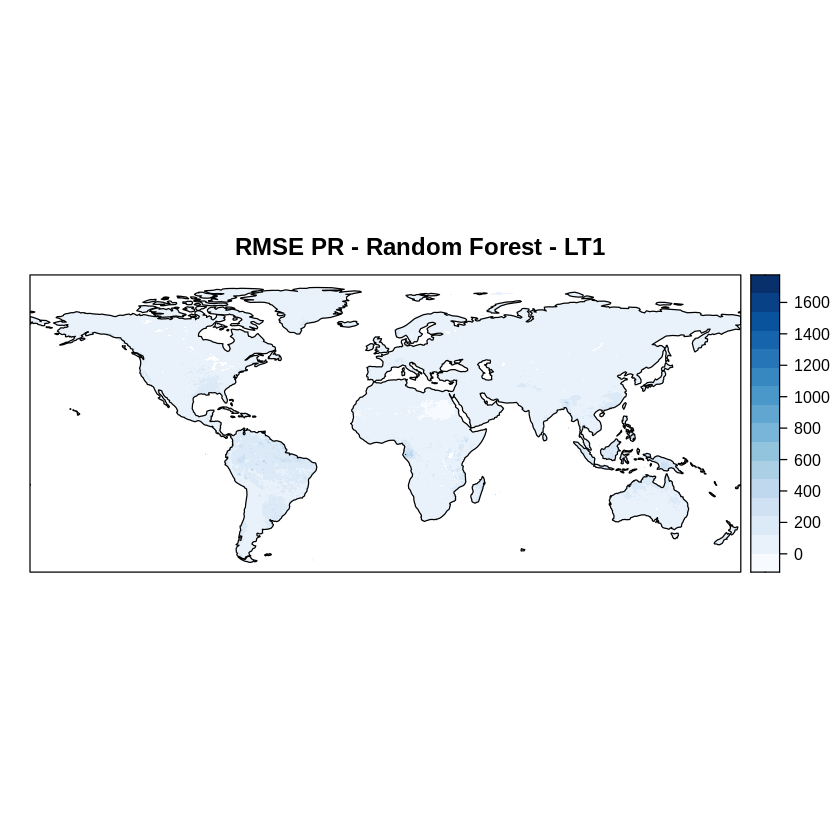

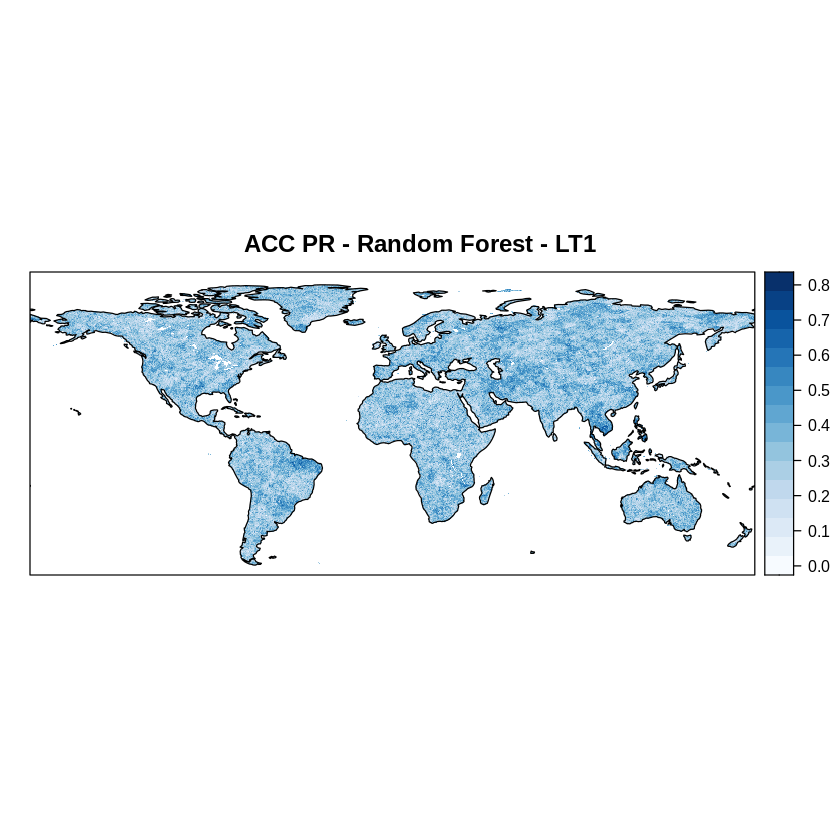

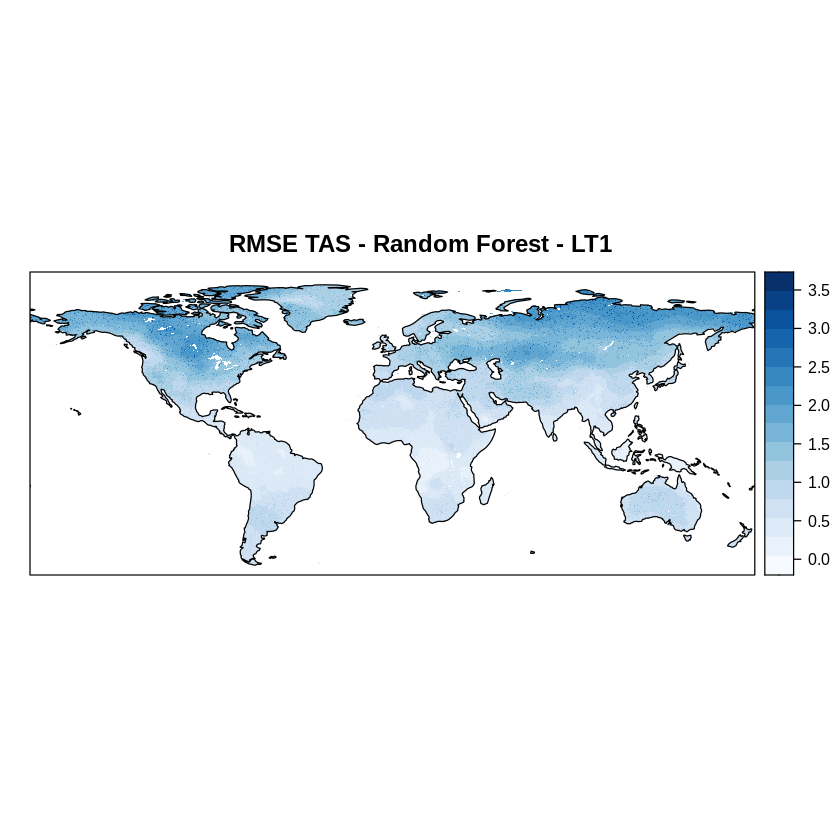

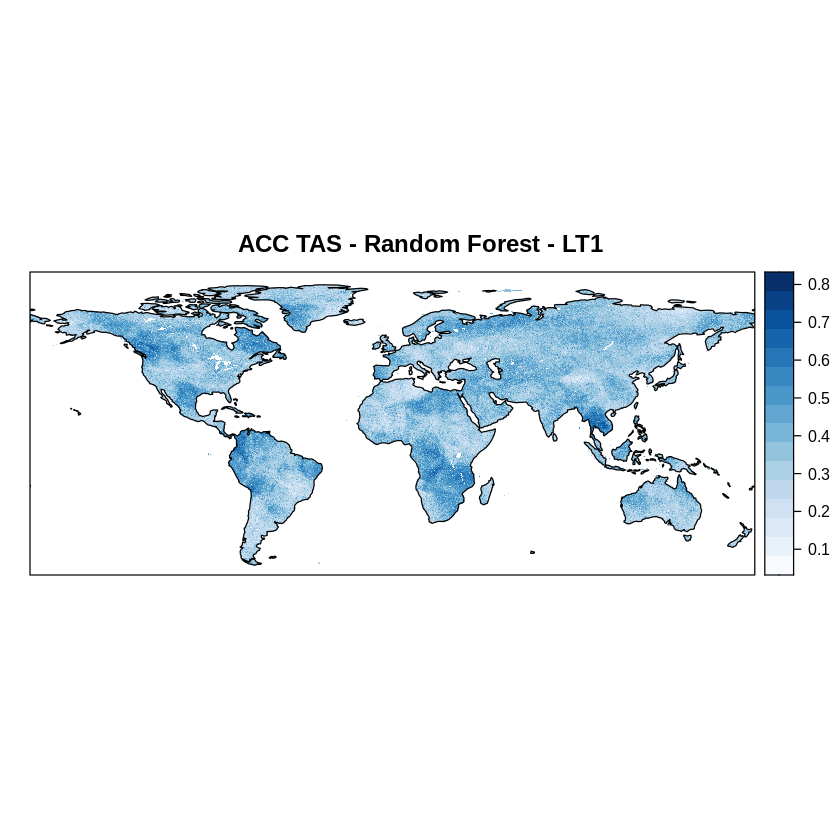

In [21]:
spatialPlot(rmse_pr_rf_LT1, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'RMSE PR - Random Forest - LT1')
spatialPlot(acc_pr_rf_LT1, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'ACC PR - Random Forest - LT1')
spatialPlot(rmse_tas_rf_LT1, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'RMSE TAS - Random Forest - LT1')
spatialPlot(acc_tas_rf_LT1, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'ACC TAS - Random Forest - LT1')

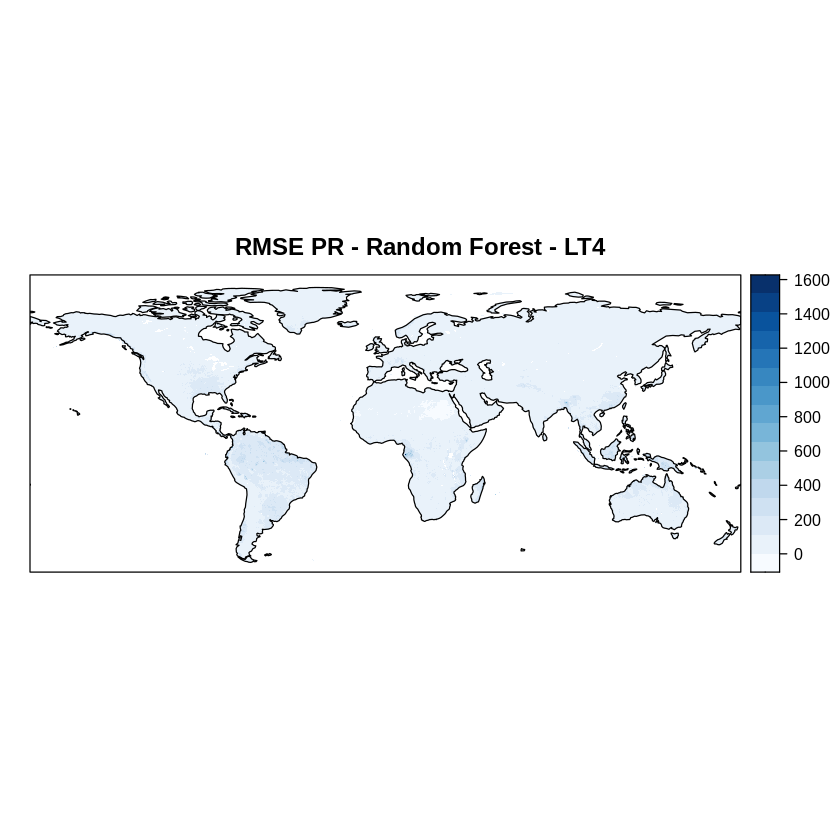

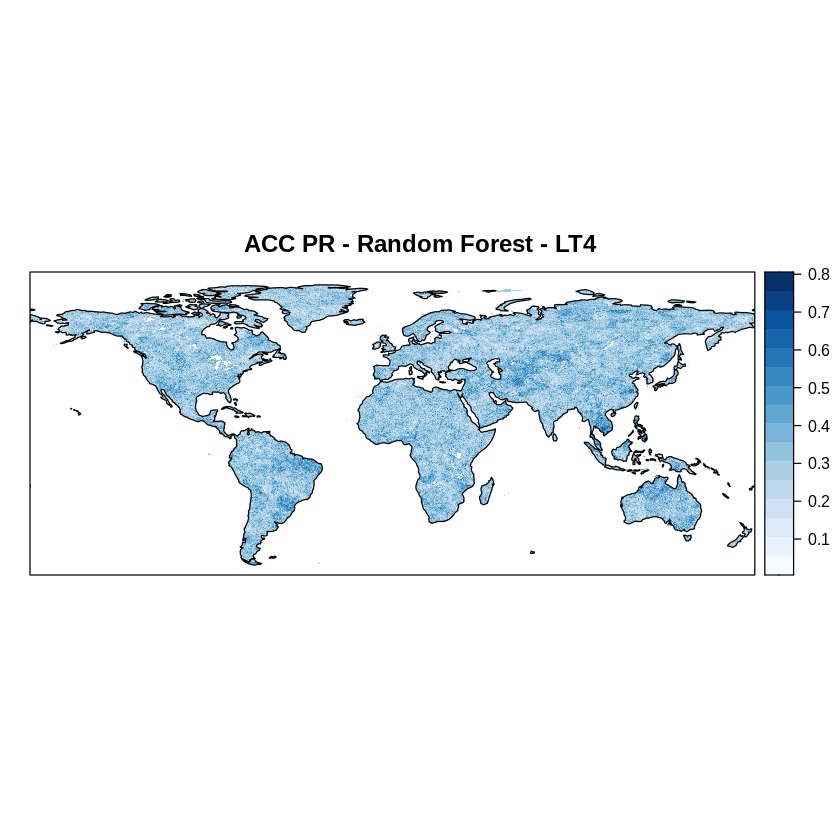

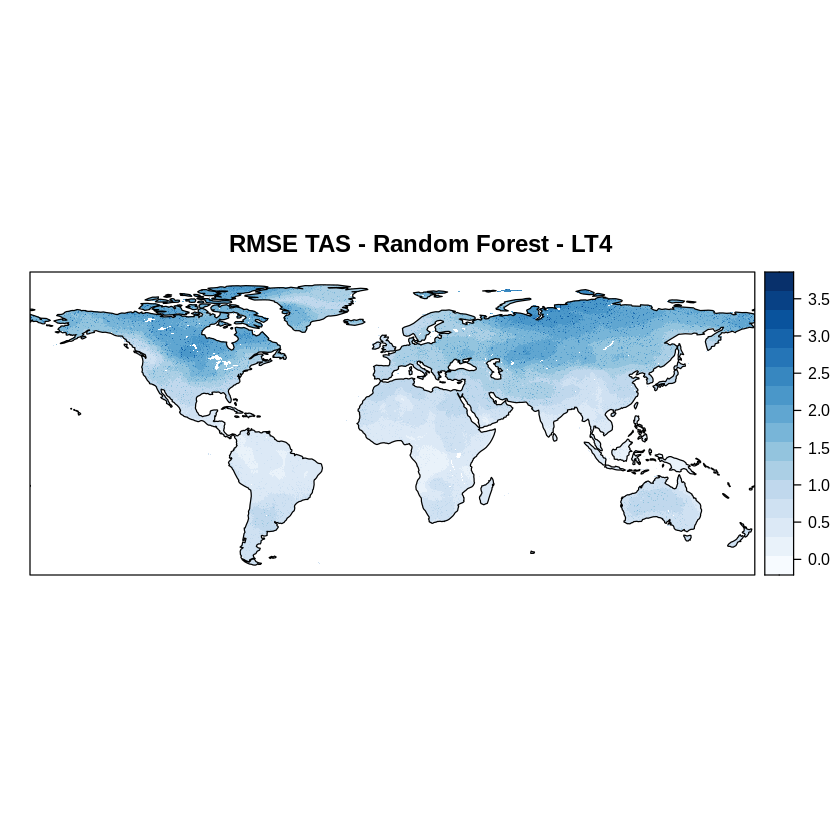

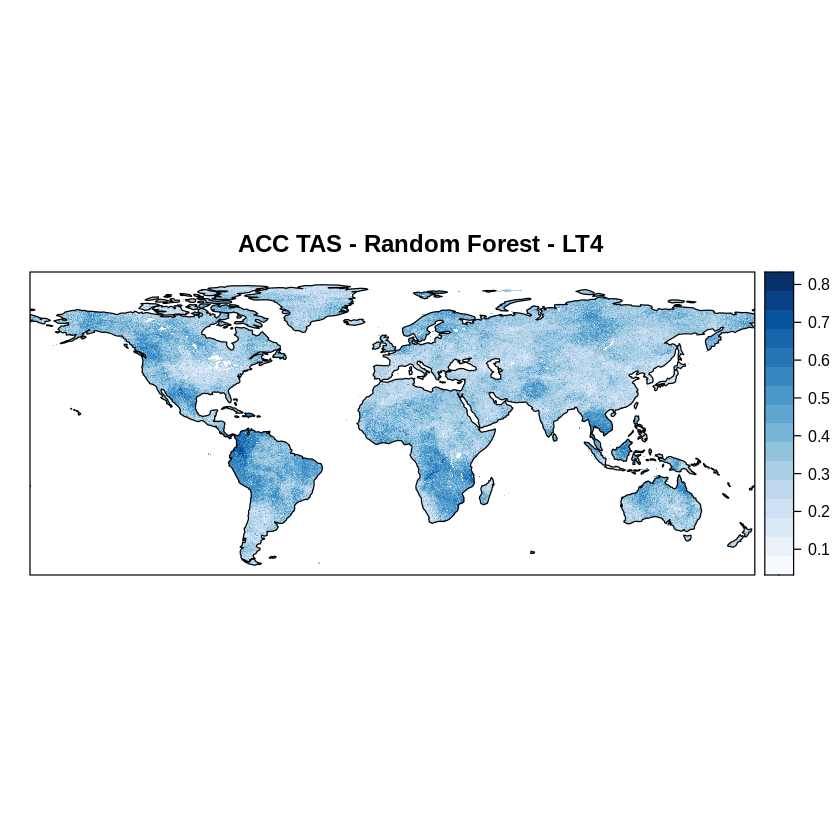

In [22]:
spatialPlot(rmse_pr_rf_LT4, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'RMSE PR - Random Forest - LT4')
spatialPlot(acc_pr_rf_LT4, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'ACC PR - Random Forest - LT4')
spatialPlot(rmse_tas_rf_LT4, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'RMSE TAS - Random Forest - LT4')
spatialPlot(acc_tas_rf_LT4, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'ACC TAS - Random Forest - LT4')

## HOLD -OUT

In [23]:
start_time = Sys.time()

rmse_pr_regression_holdout = matrix(NA, nrow = length(data_MAM$xyCoords$y), ncol = length(data_MAM$xyCoords$x))
acc_pr_regression_holdout = matrix(NA, nrow = length(data_MAM$xyCoords$y), ncol = length(data_MAM$xyCoords$x))
for(i in 1:length(data_MAM$xyCoords$x)){
    for(j in 1:length(data_MAM$xyCoords$y)){
        if(length(which(is.na(data_MAM$Data[,j,i])==FALSE))>2){
            indices_MAM$grid <- as.numeric(data_MAM$Data[, j, i])
            n = dim(indices_MAM)[1]
            set.seed(2)
            indtrain = sample(1:n, round(0.5*n))
            indtest = setdiff(1:n, indtrain)
            dataset.train = indices_MAM[indtrain, ]
            dataset.test = indices_MAM[indtest, ]
            mod= model_rf = randomForest(grid ~ ., dataset.train,ntree = nTrees_pr[j,i])

            pred= predict(mod, dataset.test)
                
            rmse_pr_regression_holdout[j,i] = rmse(dataset.test$grid,pred)
            acc_pr_regression_holdout[j,i] = acc(dataset.test$grid,pred)
        }
    }
}


end_time = Sys.time()
print(end_time - start_time)

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning messa

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning messa

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning messa

Time difference of 11.27955 mins


In [24]:
start_time = Sys.time()

rmse_tas_regression_holdout = matrix(NA, nrow = length(data_MAM_temp$xyCoords$y), ncol = length(data_MAM_temp$xyCoords$x))
acc_tas_regression_holdout = matrix(NA, nrow = length(data_MAM_temp$xyCoords$y), ncol = length(data_MAM_temp$xyCoords$x))
for(i in 1:length(data_MAM_temp$xyCoords$x)){
    for(j in 1:length(data_MAM_temp$xyCoords$y)){
        if(length(which(is.na(data_MAM_temp$Data[,j,i])==FALSE))>2){
            indices_MAM$grid <- as.numeric(data_MAM_temp$Data[, j, i])
            n = dim(indices_MAM)[1]
            set.seed(2)
            indtrain = sample(1:n, round(0.5*n))
            indtest = setdiff(1:n, indtrain)
            dataset.train = indices_MAM[indtrain, ]
            dataset.test = indices_MAM[indtest, ]
            mod= model_rf = randomForest(grid ~ ., dataset.train,ntree = nTrees_tas[j,i])

            pred= predict(mod, dataset.test)
                
            rmse_tas_regression_holdout[j,i] = rmse(dataset.test$grid,pred)
            acc_tas_regression_holdout[j,i] = acc(dataset.test$grid,pred)
        }
    }
}


end_time = Sys.time()
print(end_time - start_time)

Time difference of 5.299589 mins


In [25]:
makeC4R = function(data, template) {  # creates a C4R object from the "data" matrix
  C4R = template; C4R$Data = data; attributes(C4R$Data) = attributes(template$Data)
  return(C4R)
}
template = subsetDimension(data_MAM, dimension = "time", indices = 1)
rmse_pr_regression_holdout= makeC4R(rmse_pr_regression_holdout,template)
acc_pr_regression_holdout= makeC4R(acc_pr_regression_holdout,template)

rmse_tas_regression_holdout= makeC4R(rmse_tas_regression_holdout,template)
acc_tas_regression_holdout= makeC4R(acc_tas_regression_holdout,template)

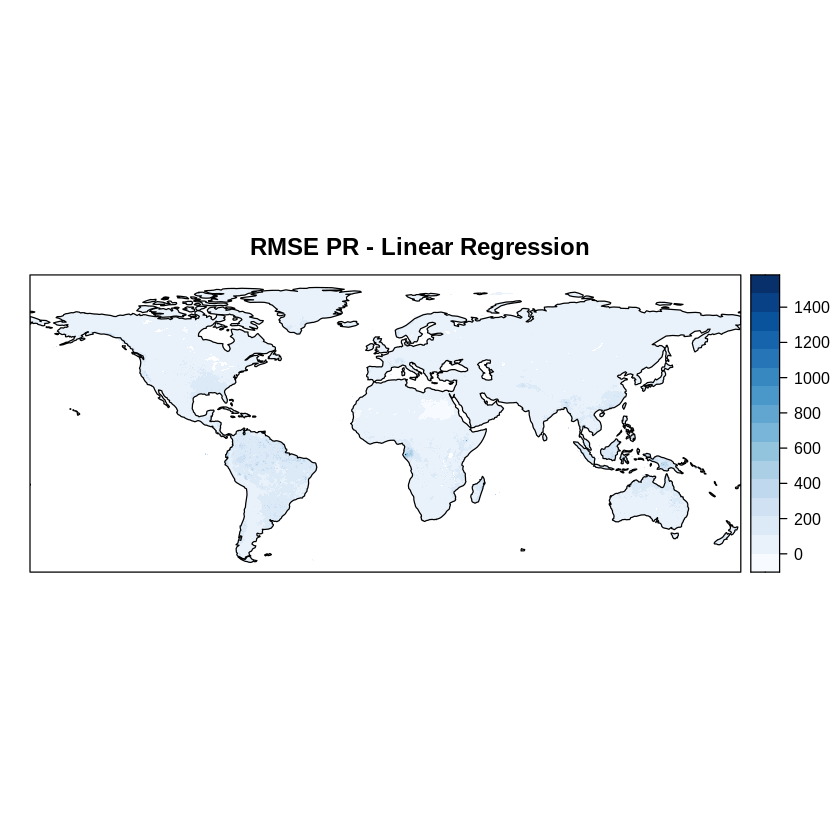

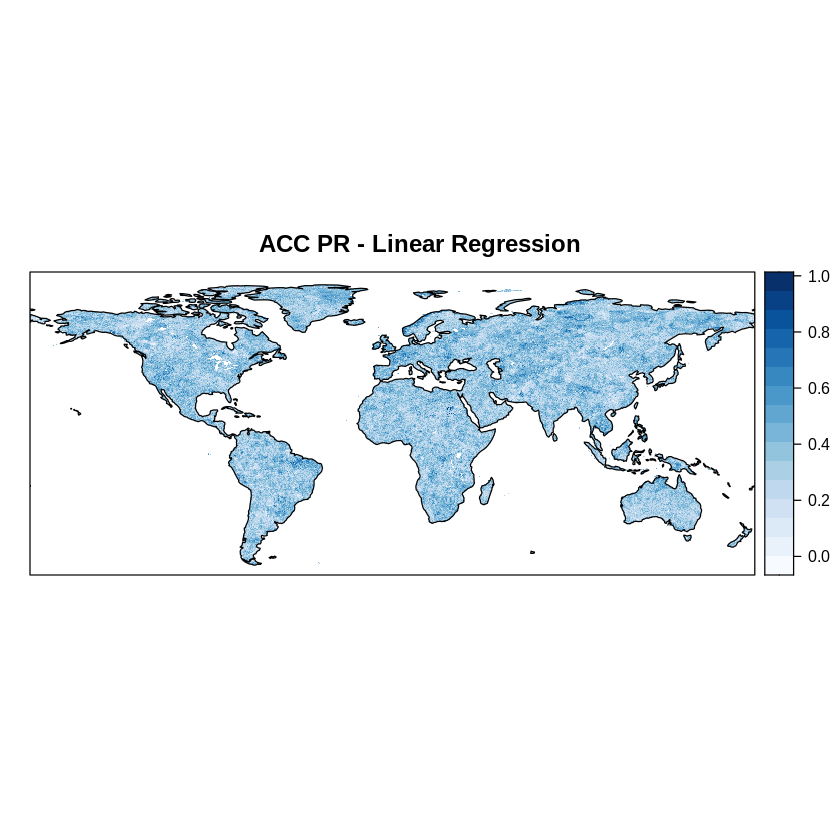

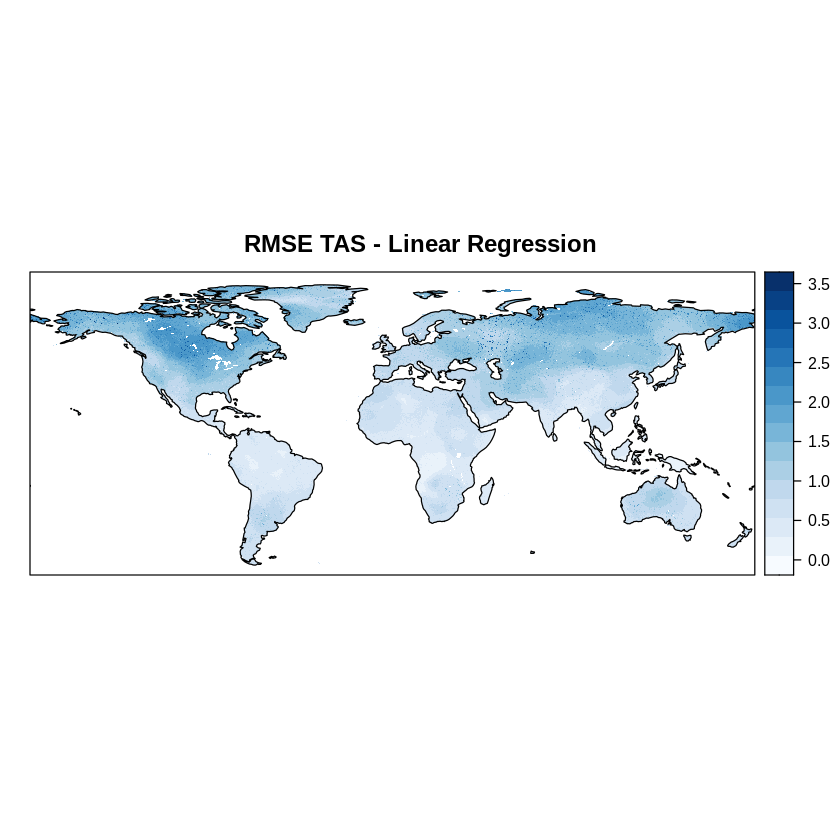

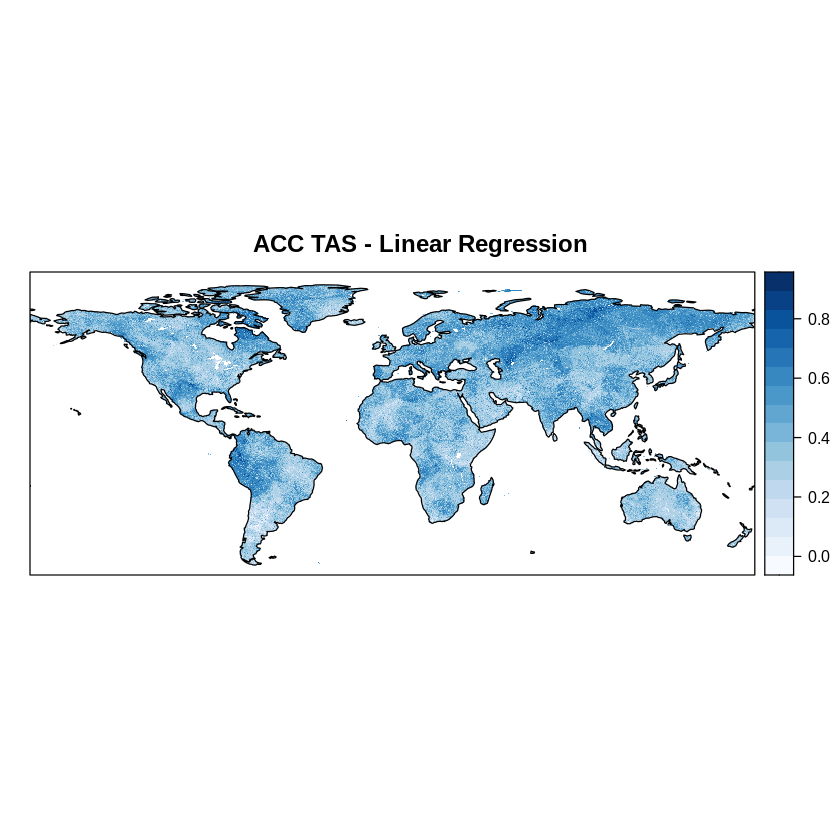

In [26]:
spatialPlot(rmse_pr_regression_holdout, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'RMSE PR - Linear Regression')
spatialPlot(acc_pr_regression_holdout, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'ACC PR - Linear Regression')
spatialPlot(rmse_tas_regression_holdout, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'RMSE TAS - Linear Regression')
spatialPlot(acc_tas_regression_holdout, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'ACC TAS - Linear Regression')